In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import seaborn as sns

In [ ]:
def calculate_age(birthDate):
    #birthDate=str(birthDate)
    d,m,y = birthDate.split('-')
    if int(y) < 21: y='20'+y
    else: y= '19'+y
    b = date(int(y),int(m),int(d))
    today=date.today()
    return today.year - b.year - ((today.month, today.day) <(b.month, b.day))

def yrs_mon_to_month(s):
    sp=re.split('yrs|mon',s)
    return int(sp[0])*12 + int(sp[1])

def encode_description(X):
    '''

    '''
    X=X.drop('PERFORM_CNS.SCORE', axis=1) # drop PERFORM_CNS.SCORE
    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('No Bureau History Available', 
                                     'Not Scored: Sufficient History Not Available','Not Scored: Not Enough Info available on the customer',
                                     'Not Scored: No Activity seen on the customer (Inactive)', 
                                     'Not Scored: No Updates available in last 36 months', 'Not Scored: Only a Guarantor'),(0, 0, 0, 0, 0, 0))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('L-Very High Risk', 'M-Very High Risk', 
                                     'Not Scored: More than 50 active Accounts found'), (1, 1, 1))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('J-High Risk', 'K-High Risk'), (2, 2))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('H-Medium Risk', 'I-Medium Risk'), (3, 3))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('E-Low Risk', 'F-Low Risk', 'G-Low Risk'), (4, 4, 4))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('A-Very Low Risk', 'B-Very Low Risk',
                                      'C-Very Low Risk', 'D-Very Low Risk'), (5, 5, 5, 5))
    return X

def get_balance(df):
    # down sampling negative instances(nondefault), keep all the positive instances
    nondefault=df[df.loan_default==0].sample(n=df.loan_default.value_counts()[1], random_state=0)
    default=df[df.loan_default==1]
    df_balance= default.append(nondefault, ignore_index=True)
    df_balance=df_balance.sample(n=len(df_balance))
    return df_balance

In [ ]:
def preprocess(df):
    # transform birthDate to age
    df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x: calculate_age(x))
    df=df.rename(columns={'Date.of.Birth': 'Age'})

    # one hot encoding Employment.Type
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df=pd.DataFrame(enc.fit_transform(df[['Employment.Type']]).toarray())
    df=df.join(enc_df)
    df.columns = df.columns.astype(str) 
    df=df.rename(columns={'0': 'Salaried',
                       '1': 'Self_employed',
                       '2': 'Unknown_employ'})
    df=df.drop('Employment.Type',axis=1)

    # 
    df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda s: yrs_mon_to_month(s))
    df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda s: yrs_mon_to_month(s))

    # transform DisbursalDate to month
    df['DisbursalDate']=pd.to_datetime(df['DisbursalDate'],errors='coerce',dayfirst=True).dt.month
    df=df.rename(columns={'DisbursalDate': 'DisbursalMonth'})

    # encoding DisbursalMonth
    df=pd.get_dummies(df, columns=["DisbursalMonth"], prefix=["DisbursalMonth"])
    df['DisbursalMonth_8'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_9'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_10'] = df['DisbursalMonth_8'].astype(int)

    # encoding description
    df=encode_description(df)

    # drop some columns with ID (will try encoding later)
    id_col_to_drop=['UniqueID','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID']
    df=df.drop(columns=id_col_to_drop)

    # merge asset_cost and disbursed_amount
    df['Downpayment']=df['asset_cost']-df['disbursed_amount']
    df=df.drop(['asset_cost','disbursed_amount'],axis=1)

    drop_max=['PRI.NO.OF.ACCTS','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
    for d in drop_max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    drop_2max=['Downpayment','SEC.INSTAL.AMT']
    for d in drop_2max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    # 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE' has negative values
    #print('Taking logrithmic')
    df['PRI.CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE']-np.min(df['PRI.CURRENT.BALANCE'])
    df['SEC.CURRENT.BALANCE']=df['SEC.CURRENT.BALANCE']-np.min(df['SEC.CURRENT.BALANCE'])

    # # without 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE'
    # to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
    #    'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
    #    'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
    #    'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
    #    'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
    #    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
    #    'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment']
    to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment','PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE']
    for c in to_log_cols:
        df[c]=np.log1p(df[c])
    #print('logarithmic completed')
    # # 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE' has negative values
    # df['PRI.CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE'].apply(lambda x: np.log1p(x) if x>=0 else -np.log1p(np.abs(x)))
    # df['SEC.CURRENT.BALANCE']=df['SEC.CURRENT.BALANCE'].apply(lambda x: np.log1p(x) if x>=0 else -np.log1p(np.abs(x)))

    # down sample
    df=get_balance(df)
    
    return df

In [ ]:
train_raw=pd.read_csv('train_LTFS.csv')
train=train_raw.copy()
test_raw=pd.read_csv('test_LTFS.csv')

In [ ]:
train=preprocess(train)

In [ ]:
train.describe().iloc[:,:10]

,ltv,Age,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS
count,101218.000000,101218.000000,101218.0,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000
mean,4.324793,36.418680,1.0,0.829131,0.075658,0.155654,0.023059,0.001927,1.602106,0.697988
std,0.167072,9.773339,0.0,0.376396,0.264452,0.362529,0.150092,0.043850,2.068875,0.875947
min,2.719320,20.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.261270,28.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.367294,35.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.444297,43.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.386294
max,4.564348,66.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.872118


In [ ]:
train.describe().iloc[:,11:20]

,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT
count,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.00000,101218.000000,101218.000000
mean,0.101777,15.732441,4.615374,4.601921,0.024244,0.013866,0.00443,13.265272,0.175765
std,0.287222,0.072092,5.796790,5.788117,0.172636,0.119126,0.06075,0.061820,1.423458
min,0.000000,15.354523,0.000000,0.000000,0.000000,0.000000,0.00000,13.033554,0.000000
25%,0.000000,15.714374,0.000000,0.000000,0.000000,0.000000,0.00000,13.261513,0.000000
50%,0.000000,15.714374,0.000000,0.000000,0.000000,0.000000,0.00000,13.261513,0.000000
75%,0.000000,15.718952,10.931338,10.915107,0.000000,0.000000,0.00000,13.261513,0.000000
max,2.944439,17.956132,18.273617,18.270146,3.663562,3.135494,1.94591,17.221204,17.216708


In [ ]:
train.describe().iloc[:,20:]

,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Salaried,Self_employed,Unknown_employ,DisbursalMonth_8,DisbursalMonth_9,DisbursalMonth_10,Downpayment
count,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000,101218.000000
mean,0.172979,2.747482,0.078570,0.194757,0.066615,1.255802,1.477588,0.126115,0.500000,0.411281,0.556087,0.032633,0.291707,0.291707,0.291707,9.819315
std,1.408485,4.162787,0.834467,0.408672,0.227927,1.430023,1.679026,0.334175,0.500002,0.492068,0.496847,0.177674,0.454550,0.454550,0.454550,0.497486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.293550
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.455089
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.768069
75%,0.000000,7.559038,0.000000,0.000000,0.000000,2.564949,3.178054,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.165236
max,17.216708,16.672488,14.411045,3.367296,2.564949,5.602119,6.150603,3.135494,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.989228


In [ ]:
train.columns

Index(['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'Salaried', 'Self_employed', 'Unknown_employ',
       'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
       'Downpayment'],
      dtype='object')

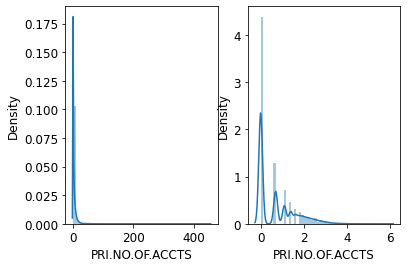

In [ ]:
plt.subplot(121)
sns.distplot(train_raw['PRI.NO.OF.ACCTS'])
plt.subplot(122)
sns.distplot(train['PRI.NO.OF.ACCTS'])

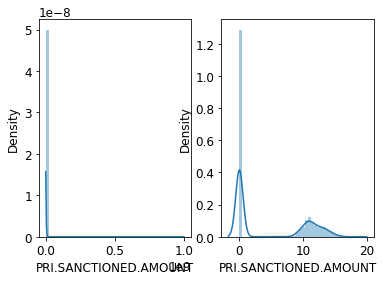

In [ ]:
plt.subplot(121)
sns.distplot(train_raw['PRI.SANCTIONED.AMOUNT'])
plt.subplot(122)
sns.distplot(train['PRI.SANCTIONED.AMOUNT'])

In [ ]:

X = train.drop('loan_default',1) 
y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)
def fit_LR(data):
    lr=LogisticRegression(class_weight='balanced')
    #return np.mean(cross_val_score(lr, data, y_train, cv=3,scoring="f1_weighted"))
    return np.mean(cross_val_score(lr, data, y_train, cv=5,scoring="f1_weighted"))


# mi_cols=['AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
#        'CREDIT.HISTORY.LENGTH', 'Salaried', 'Aadhar_flag',
#        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Self_employed',
#        'PRI.NO.OF.ACCTS', 'Downpayment', 'PRI.OVERDUE.ACCTS', 'VoterID_flag',
#        'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv'] # first round pick according to the full model
# mi_cols=['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
#        'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
#        'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
#        'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
#        'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
#        'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
#        'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
#        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
#        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
#        'loan_default', 'Salaried', 'Self_employed', 'Unknown_employ',
#        'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
#        'Downpayment']
#mi_cols=np.array(mi_cols)
cor_cols=['AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
       'CREDIT.HISTORY.LENGTH', 'Salaried', 'Aadhar_flag',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Self_employed',
       'PRI.NO.OF.ACCTS', 'Downpayment', 'PRI.OVERDUE.ACCTS', 'VoterID_flag',
       'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv']

selected=[]
global_select=[]
global_acc=0.0
last_acc=0.0#fit(train[selected].to_numpy())
best_acc=0.0
best_col=""
total=count=len(cor_cols)
miss=0
while((count>0)):
    for i in range(len(cor_cols)):
        current=cor_cols[i]
        if(current in selected):
            continue
        cols=np.append(selected,current)
        data=X_train[cols].to_numpy() #####
        acc=fit_LR(data)
        if(acc>best_acc):
            best_acc=acc
            best_col=current
    if(best_acc>last_acc):
        last_acc=best_acc
        global_acc=best_acc
        selected=np.append(selected,best_col)
        # f=np.where(mi_cols==current)
        # if(f[0].size>0):
        #     mi_cols=np.delete(mi_cols,f[0][0])
        miss=0
        global_select=selected
        print("iter:"+str(total-count))
        print("found:"+str(selected)+" "+str(last_acc))
    else:
        # selected=np.append(selected,mi_cols[0])
        # mi_cols=np.delete(mi_cols,0)
        # data=X_train[selected].to_numpy()
        # acc=fit_LR(data)
        # print("iter:"+str(total-count))
        # print("miss:"+str(selected)+" "+str(acc))
        # last_acc=acc
        # best_acc=acc
        # if(acc>global_acc):
        #     global_acc=acc
        #     global_select=selected
        miss+=1
        print('miss',miss)
    count-=1
        
    if(miss> 10):
        break

iter:0
found:['ltv'] 0.5450216299928053
iter:1
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION'] 0.5617912284297469
iter:2
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag'] 0.5663842218284458
iter:3
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag' 'NO.OF_INQUIRIES'] 0.5705204182836007
iter:4
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag' 'NO.OF_INQUIRIES'
 'PRI.OVERDUE.ACCTS'] 0.5736791094370238
iter:5
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag' 'NO.OF_INQUIRIES'
 'PRI.OVERDUE.ACCTS' 'Salaried'] 0.5767318043400069
iter:6
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag' 'NO.OF_INQUIRIES'
 'PRI.OVERDUE.ACCTS' 'Salaried' 'PRI.ACTIVE.ACCTS'] 0.5779162392739228
iter:7
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag' 'NO.OF_INQUIRIES'
 'PRI.OVERDUE.ACCTS' 'Salaried' 'PRI.ACTIVE.ACCTS' 'Aadhar_flag'] 0.5781452495022352
iter:8
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION' 'VoterID_flag' 'NO.OF_INQUIRIES'
 'PRI.OVERDUE.ACCTS' '

In [ ]:
#X = train.drop('loan_default',1) 

# X=train[['ltv', 'PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'VoterID_flag', 'NO.OF_INQUIRIES',
#  'Salaried', 'PRI.OVERDUE.ACCTS', 'PRI.NO.OF.ACCTS', 'Downpayment',
#  'Aadhar_flag']]

# X=train[['ltv','PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'Salaried', 'VoterID_flag',
#  'NO.OF_INQUIRIES', 'PRI.OVERDUE.ACCTS' ,'PRI.NO.OF.ACCTS', 'Downpayment',
#  'Self_employed']]

# X=train[['ltv' ,'PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'VoterID_flag' ,'NO.OF_INQUIRIES',
#  'PRI.OVERDUE.ACCTS' ,'PRI.NO.OF.ACCTS' ,'Salaried','Downpayment',
#  'PRI.ACTIVE.ACCTS' ,'AVERAGE.ACCT.AGE']]

X=train[['ltv' ,'PERFORM_CNS.SCORE.DESCRIPTION', 'VoterID_flag' ,'NO.OF_INQUIRIES',
 'PRI.OVERDUE.ACCTS' ,'Salaried', 'PRI.ACTIVE.ACCTS' ,'Aadhar_flag',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'PRI.NO.OF.ACCTS',
 'CREDIT.HISTORY.LENGTH' ,'AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS']]

y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
lr=LogisticRegression(class_weight='balanced').fit(X_train,y_train)#
y_vali_pred=lr.predict(X_vali)
confusion = metrics.confusion_matrix(y_vali, y_vali_pred)
print('----confusion matrix----')
print(confusion)
print('Accuracy_Score:', metrics.accuracy_score(y_vali, y_vali_pred))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, y_vali_pred))


----confusion matrix----
[[7981 7068]
 [5588 9729]]
Accuracy_Score: 0.5832180728446289
              precision    recall  f1-score   support

           0       0.59      0.53      0.56     15049
           1       0.58      0.64      0.61     15317

    accuracy                           0.58     30366
   macro avg       0.58      0.58      0.58     30366
weighted avg       0.58      0.58      0.58     30366



In [ ]:
# get importance
importance = lr.coef_[0] # LR feature importance
# summarize feature importance
for i, v in enumerate(importance):
        print('Feature: {}, Score:{}'.format (i, v))

Feature: 0, Score:1.6994050524498718
Feature: 1, Score:-0.04288996472835751
Feature: 2, Score:0.2026888768788429
Feature: 3, Score:0.4096822146649585
Feature: 4, Score:0.5217921615283648
Feature: 5, Score:-0.15976700523924478
Feature: 6, Score:-0.1422759934890303
Feature: 7, Score:-0.12453469808269127
Feature: 8, Score:0.37539239667541724
Feature: 9, Score:-0.039678445299115815
Feature: 10, Score:-0.3454277173956675
Feature: 11, Score:0.35790666068751753
Feature: 12, Score:0.04882744407359548


Text(0, 0.5, 'Features')

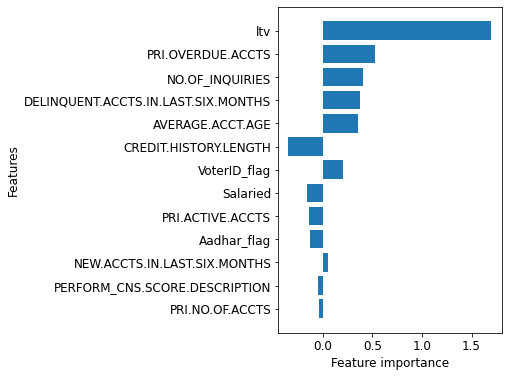

In [ ]:
sortLR= np.abs(importance).argsort()
plt.figure(figsize=(4,6))
plt.barh(X.columns[sortLR], importance[sortLR])
plt.xlabel('Feature importance')
plt.ylabel('Features')
#plt.savefig('LR_importance.png',dpi=150,bbox_inches='tight')

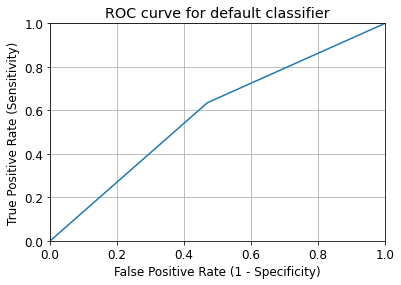

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_vali, y_vali_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85463a1c-f246-4a97-953d-d1ccc73b61e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>